In [6]:
import numpy as np
import os
import random
import torch

from torch.utils.data import DataLoader, random_split
from torchvision import transforms

from Callbacks import EarlyStopping
from TransferLearningModel import TransferLearningModel
from utils import DICOMCoarseDataset

In [7]:
BASE_DIR = "C:/Users/Dominik Hahn/OneDrive/Studium/Master/Masterarbeit/Daten"
# BASE_DIR = "C:/Users/domin/OneDrive/Studium/Master/Masterarbeit/Daten"
seed = 41
batch_size = 32
classes = ["nodule", "non-nodule"]
train_ratio = 0.6
scenario = 2

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

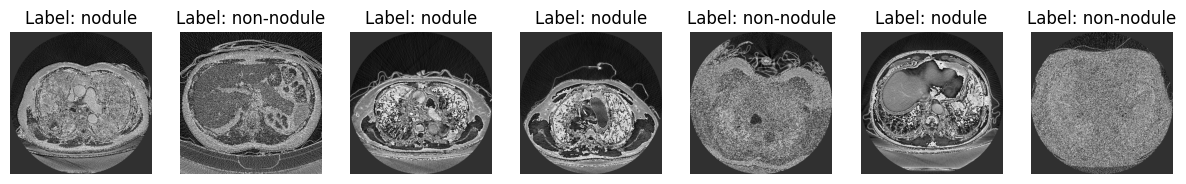

In [8]:
dataset = DICOMCoarseDataset(root_dir=BASE_DIR, num_images_per_class=len(os.listdir(os.path.join(BASE_DIR, "nodule"))), classes=classes, scenario=scenario)
# dataset = DICOMCoarseDataset(root_dir=BASE_DIR, num_images_per_class=100, classes=classes, scenario=1)
dataset.visualize_images(num_images=7)

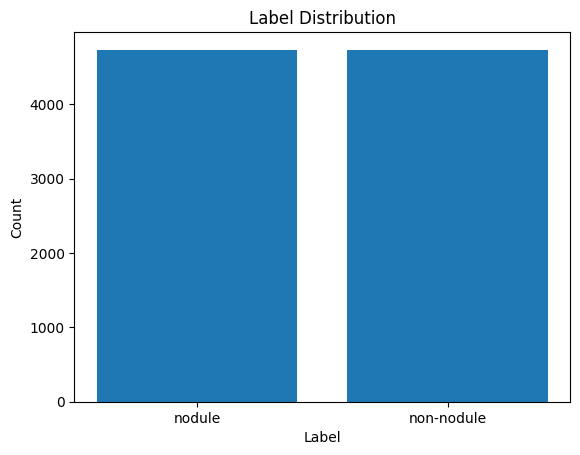

In [9]:
dataset.display_label_distribution()

In [10]:
train_size = int(train_ratio * len(dataset))
val_size = int(((1-train_ratio)/2) * len(dataset)) 
test_size = len(dataset) - train_size - val_size

print(f"Train size: {train_size} --- Validation size: {val_size} --- Test size: {test_size}")

Train size: 5683 --- Validation size: 1894 --- Test size: 1895


In [ ]:
model_names = ["resnet", "densenet", "inception", "efficientnet", "efficientnet2", "efficientnet3", "vit"]
best_val_loss = float('inf')
best_model = None

for model_name in model_names:
    print(f"Processing model: {model_name}")
    current_model = TransferLearningModel(classes, model_name, data_augmentation=True, fine=False, scenario=scenario)

    # Ensure transforms are correctly applied based on model requirements
    current_model.train_transforms, current_model.test_transforms = current_model.get_transforms()
    train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

    # Apply specific transforms to each subset
    train_dataset.dataset.transform = current_model.train_transforms
    val_dataset.dataset.transform = current_model.test_transforms
    test_dataset.dataset.transform = current_model.test_transforms

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize early stopping
    early_stopping = EarlyStopping(patience=10)

    # Train the current model
    current_model.train(train_loader, val_loader, early_stopping, epochs=50)

    # Track the best model based on validation loss
    final_val_loss = current_model.val_losses[-1]
    if final_val_loss < best_val_loss:
        best_val_loss = final_val_loss
        best_model = current_model

print(f"The best model is {best_model.model_name} with a validation loss of {best_val_loss:.4f}")

Processing model: resnet
Epoch 1/50 ----- Loss: 0.2480, Accuracy: 89.85% ----- Validation Loss: 0.1275, Validation Accuracy: 95.72%
Epoch 2/50 ----- Loss: 0.1186, Accuracy: 96.06% ----- Validation Loss: 0.0732, Validation Accuracy: 98.10%
Epoch 3/50 ----- Loss: 0.0942, Accuracy: 96.76% ----- Validation Loss: 0.0628, Validation Accuracy: 98.52%
Epoch 4/50 ----- Loss: 0.0814, Accuracy: 97.17% ----- Validation Loss: 0.0523, Validation Accuracy: 98.68%
Epoch 5/50 ----- Loss: 0.0725, Accuracy: 97.52% ----- Validation Loss: 0.0411, Validation Accuracy: 98.79%
Epoch 6/50 ----- Loss: 0.0652, Accuracy: 97.82% ----- Validation Loss: 0.0389, Validation Accuracy: 98.89%
Epoch 7/50 ----- Loss: 0.0573, Accuracy: 98.08% ----- Validation Loss: 0.0335, Validation Accuracy: 99.21%
Epoch 8/50 ----- Loss: 0.0583, Accuracy: 98.12% ----- Validation Loss: 0.0308, Validation Accuracy: 99.26%
Epoch 9/50 ----- Loss: 0.0493, Accuracy: 98.42% ----- Validation Loss: 0.0290, Validation Accuracy: 99.16%
Epoch 10/50 

c:\Users\Dominik Hahn\Documents\GitHub\Masterarbeit\.venv\lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)


Epoch 1/50 ----- Loss: 0.1587, Accuracy: 94.30% ----- Validation Loss: 0.0795, Validation Accuracy: 97.41%
Epoch 2/50 ----- Loss: 0.0628, Accuracy: 98.17% ----- Validation Loss: 0.0523, Validation Accuracy: 98.20%
Epoch 3/50 ----- Loss: 0.0443, Accuracy: 98.72% ----- Validation Loss: 0.0373, Validation Accuracy: 98.89%
Epoch 4/50 ----- Loss: 0.0332, Accuracy: 99.16% ----- Validation Loss: 0.0330, Validation Accuracy: 99.37%
Epoch 5/50 ----- Loss: 0.0265, Accuracy: 99.35% ----- Validation Loss: 0.0259, Validation Accuracy: 99.42%
Epoch 6/50 ----- Loss: 0.0223, Accuracy: 99.49% ----- Validation Loss: 0.0219, Validation Accuracy: 99.47%
Epoch 7/50 ----- Loss: 0.0189, Accuracy: 99.67% ----- Validation Loss: 0.0190, Validation Accuracy: 99.52%
Epoch 8/50 ----- Loss: 0.0162, Accuracy: 99.75% ----- Validation Loss: 0.0161, Validation Accuracy: 99.74%
Epoch 9/50 ----- Loss: 0.0138, Accuracy: 99.86% ----- Validation Loss: 0.0149, Validation Accuracy: 99.68%
Epoch 10/50 ----- Loss: 0.0124, Accur

Best model: efficientnet3


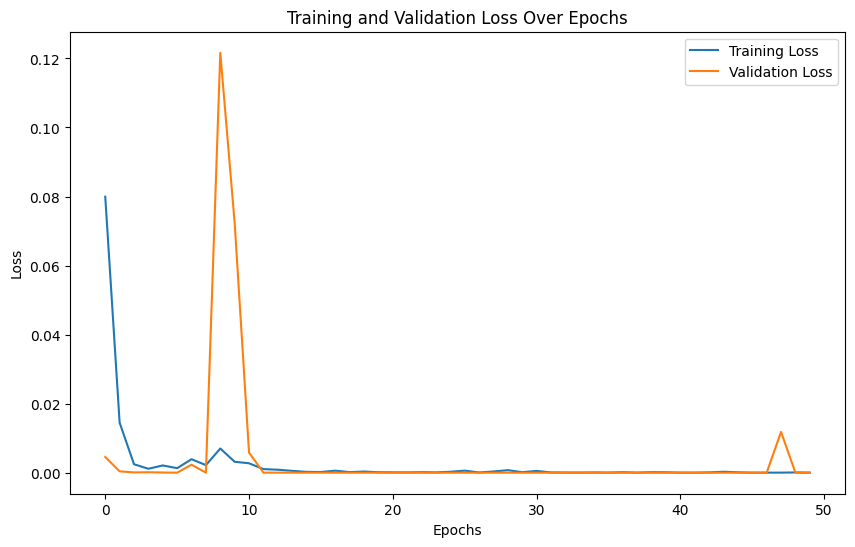

In [12]:
print(f"Best model: {best_model.model_name}")
best_model.plot_loss()

Best model: efficientnet3
8.175725525676178e-07
Evaluation Accuracy on unseen data: 100.0


<Figure size 1000x800 with 0 Axes>

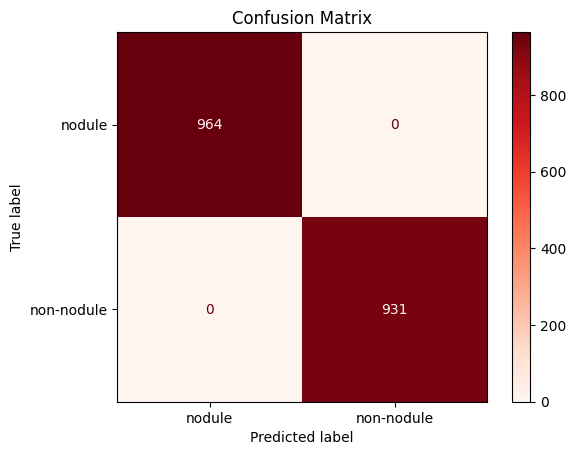

In [14]:
print(f"Best model: {best_model.model_name}")
checkpoint = torch.load(f"weights/coarse/scenario{scenario}/{best_model.model_name}.pt", weights_only=False)
best_model.model.load_state_dict(checkpoint['model_state_dict'])
loss = checkpoint["loss"]
print(loss)
best_model.evaluate(test_loader)

8.175725525676178e-07
Evaluation Accuracy on unseen data: 100.0


<Figure size 1000x800 with 0 Axes>

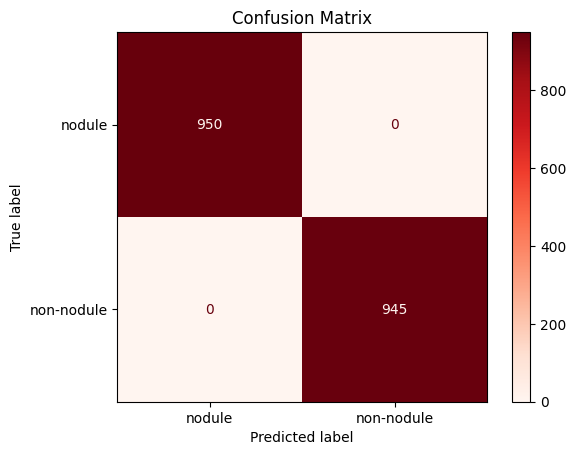

In [ ]:
# test_model_name = "efficientnet3"
# test_model = TransferLearningModel(classes, test_model_name, data_augmentation=False, scenario=2)
# dataset = DICOMCoarseDataset(root_dir=BASE_DIR, num_images_per_class=len(os.listdir(os.path.join(BASE_DIR, "nodule"))), classes=classes, scenario=2)
# train_size = int(train_ratio * len(dataset))
# val_size = int(((1-train_ratio)/2) * len(dataset)) 
# test_size = len(dataset) - train_size - val_size
# # Ensure transforms are correctly applied based on model requirements
# test_model.train_transforms, test_model.test_transforms = test_model.get_transforms()
# train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# test_dataset.dataset.transform = test_model.test_transforms

# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# checkpoint = torch.load(f"weights/coarse/scenario2/{test_model.model_name}.pt", weights_only=False)
# test_model.model.load_state_dict(checkpoint['model_state_dict'])
# loss = checkpoint["loss"]
# print(loss)
# test_model.evaluate(test_loader)